# Position Reconstruction for XeBRA - Neural Networks

**Status:** August 2019

Position reconstruction for XeBRA using a feedforward neural network with Keras.
Purpose of this notebook: Keras Hyperparameter Tuning and comparison results.

In [22]:
#############################################
## Imports:
#############################################

from __future__ import print_function
import numpy as np

from hyperopt import Trials, STATUS_OK, tpe
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from keras.optimizers import SGD,Adam

from hyperas import optim
from hyperas.distributions import choice, uniform

import os
import glob
import uproot
import pandas as pd

import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline

In [2]:
#############################################
## Preparing the Data
#############################################

## Selection of file(s) to be used:
filename_list = glob.glob("/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_*.root")                
file_split_train = 0.9 # fraction of file used for training

## Import as pandas dataframes
branches= ['xp_pri','yp_pri','zp_pri','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect
import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)
_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame
for _chunk in uproot.iterate(filename_list, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect=_chunk_collect.append(_chunk)

## Normalize to hits fractions
_chunk_collect['pmthits'] = (_chunk_collect['pmthits'] / _chunk_collect['ntpmthits'])

## Separate hits for individual PMTs
## Takes a while to calculate...
for i in range(1,8):
    _chunk_collect['pmthits_'+str(i)] = pd.Series([tupl[i] for tupl in np.asarray(_chunk_collect['pmthits'])], index=_chunk_collect.index)

_chunk_collect = _chunk_collect.drop(columns=['pmthits'])
_chunk_collect = _chunk_collect.drop(columns=['ntpmthits'])

## Separate labels and features
features=['pmthits_1','pmthits_7']
labels=['xp_pri','yp_pri']

## Split arrays into (random) train and test subsets.
## Could also be done with sklearn.model_selection.train_test_split,
## but already randomized from simulation (see plots bleow).
train_label     = _chunk_collect.loc[:int(np.floor(_chunk_collect.shape[0]*file_split_train))-1,labels]
predict_label   = _chunk_collect.loc[int(np.floor(_chunk_collect.shape[0]*file_split_train)):,labels]
train_feature   = _chunk_collect.loc[:int(np.floor(_chunk_collect.shape[0]*file_split_train))-1,features[0]:features[1]]
predict_feature = _chunk_collect.loc[int(np.floor(_chunk_collect.shape[0]*file_split_train)):,features[0]:features[1]]

del(_chunk_collect)

## Convert to numpy arrays
train_feature   = train_feature.to_numpy()
train_label     = train_label.to_numpy()
predict_feature = predict_feature.to_numpy()
predict_label   = predict_label.to_numpy()

## Normalize labels to [-0.5, 0.5] to make network easier to train 
## as using smaller, centered values is often better.
## Have to rescale later.
scaling_factor = 70
train_label = train_label/scaling_factor
predict_label = predict_label/scaling_factor

## Batch Size

In [18]:
'''parameters = np.array([1024,  512,  256,  128,   64,   32,   16,    8])
parameters_number = len(parameters) 

list_par_means = np.array([np.nan]*parameters_number)
list_par_stds = np.array([np.nan]*parameters_number)

for ind, par in enumerate(parameters):
    
    print('\nParameter value '+str(par))
    
    repetitions = 5
    list_rep = np.array([np.nan]*repetitions)

    for rep in range(repetitions):

        print('Repetition '+str(rep+1)+' of '+str(repetitions))

        #############################################
        ## Function for optimizing the NN
        #############################################

        ## Building the Model
        pmts = int(7) # number of PMTs

        model = Sequential()
        model.add(Dense(64, input_shape=(pmts,)))
        model.add(Activation('relu'))
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dense(2))  # x and y
        model.add(Activation('linear'))

        ## Compiling the Model
        model.compile(optimizer=Adam(lr=0.0005),
                      loss='mean_squared_error',
                      metrics=['mean_squared_error']
                 )

        ## Training the Model
        result = model.fit(train_feature, train_label,
                           epochs=100,
                           batch_size=par,
                           validation_split=0.3,
                           verbose=0
                          )

        ## Get the lowest validation loss of the training epochs
        validation_loss = np.amin(result.history['val_loss']) 
        print('Best validation loss of epoch:', validation_loss)
        list_rep[rep] = validation_loss

    list_rep_mean = np.mean(list_rep)
    list_rep_std = np.std(list_rep)
    
    list_par_means[ind] = list_rep_mean
    list_par_stds[ind] = list_rep_std'''
    
print('Done.')

Done.


In [20]:
print('Parameter values:')
print(parameters)
print('Best validation loss of epoch - Mean over '+str(repetitions)+' iterations:')
print(list_par_means)
print('Best validation loss of epoch - Standard deviation over '+str(repetitions)+' iterations:')
print(list_par_stds)

Parameter values:
[1024  512  256  128   64   32   16    8]
Best validation loss of epoch - Mean over 5 iterations:
[0.0003668639779880781, 0.00036469135820762155, 0.00036335176550507267, 0.00036282221472873875, 0.0003638953631598917, 0.0003646485154615301, 0.0003679163898457342, 0.00037074080261224516]
Best validation loss of epoch - Standard deviation over 5 iterations:
[1.2502113469741046e-06, 8.415393212498917e-07, 4.6266941332699865e-07, 9.119272809604152e-07, 7.169807318651394e-07, 8.569344168511869e-07, 1.0870038246615715e-06, 1.1901836843939586e-06]


In [32]:
parameters      = np.array([1024,  512,  256,  128,   64,   32,   16,    8])
list_par_list   = np.array([[0.00036717881538594763, 0.00036615796174371135, 0.0003680064008967882, 0.000368166188876731, 0.0003648105230372123],  
                            [0.0003651888562487093, 0.00036489241260310843, 0.0003630361308999084, 0.0003653364651405287, 0.00036500292614585273],  
                            [0.00036251307620184016, 0.0003631969734698672, 0.00036358680553147914, 0.0003637378484752305, 0.0003637241238469465],  
                            [0.0003639909554341877, 0.0003621686339378357, 0.00036305207594004634, 0.0003634583095709483, 0.0003614410987606755],   
                            [0.0003634452991222066, 0.00036286535996995454, 0.0003638178506521163, 0.00036446462124586107, 0.0003648836848093197],   
                            [0.00036521056884106386, 0.0003636788990339954, 0.00036375654074449645, 0.0003659210221936788, 0.0003646755464944161],   
                            [0.0003662651226577711, 0.000369323359068302, 0.00036827963801700175, 0.0003671280056108824, 0.00036858582387471367],    
                            [0.0003688351116654101, 0.0003713569877459021, 0.0003707439192957719, 0.0003720271917418965]])

list_par_means = np.array([np.mean(list_par_list[i]) for i in range(len(list_par_list))])
list_par_stds = np.array([np.std(list_par_list[i]) for i in range(len(list_par_list))])
list_par_lens = np.array([len(list_par_list[i]) for i in range(len(list_par_list))])

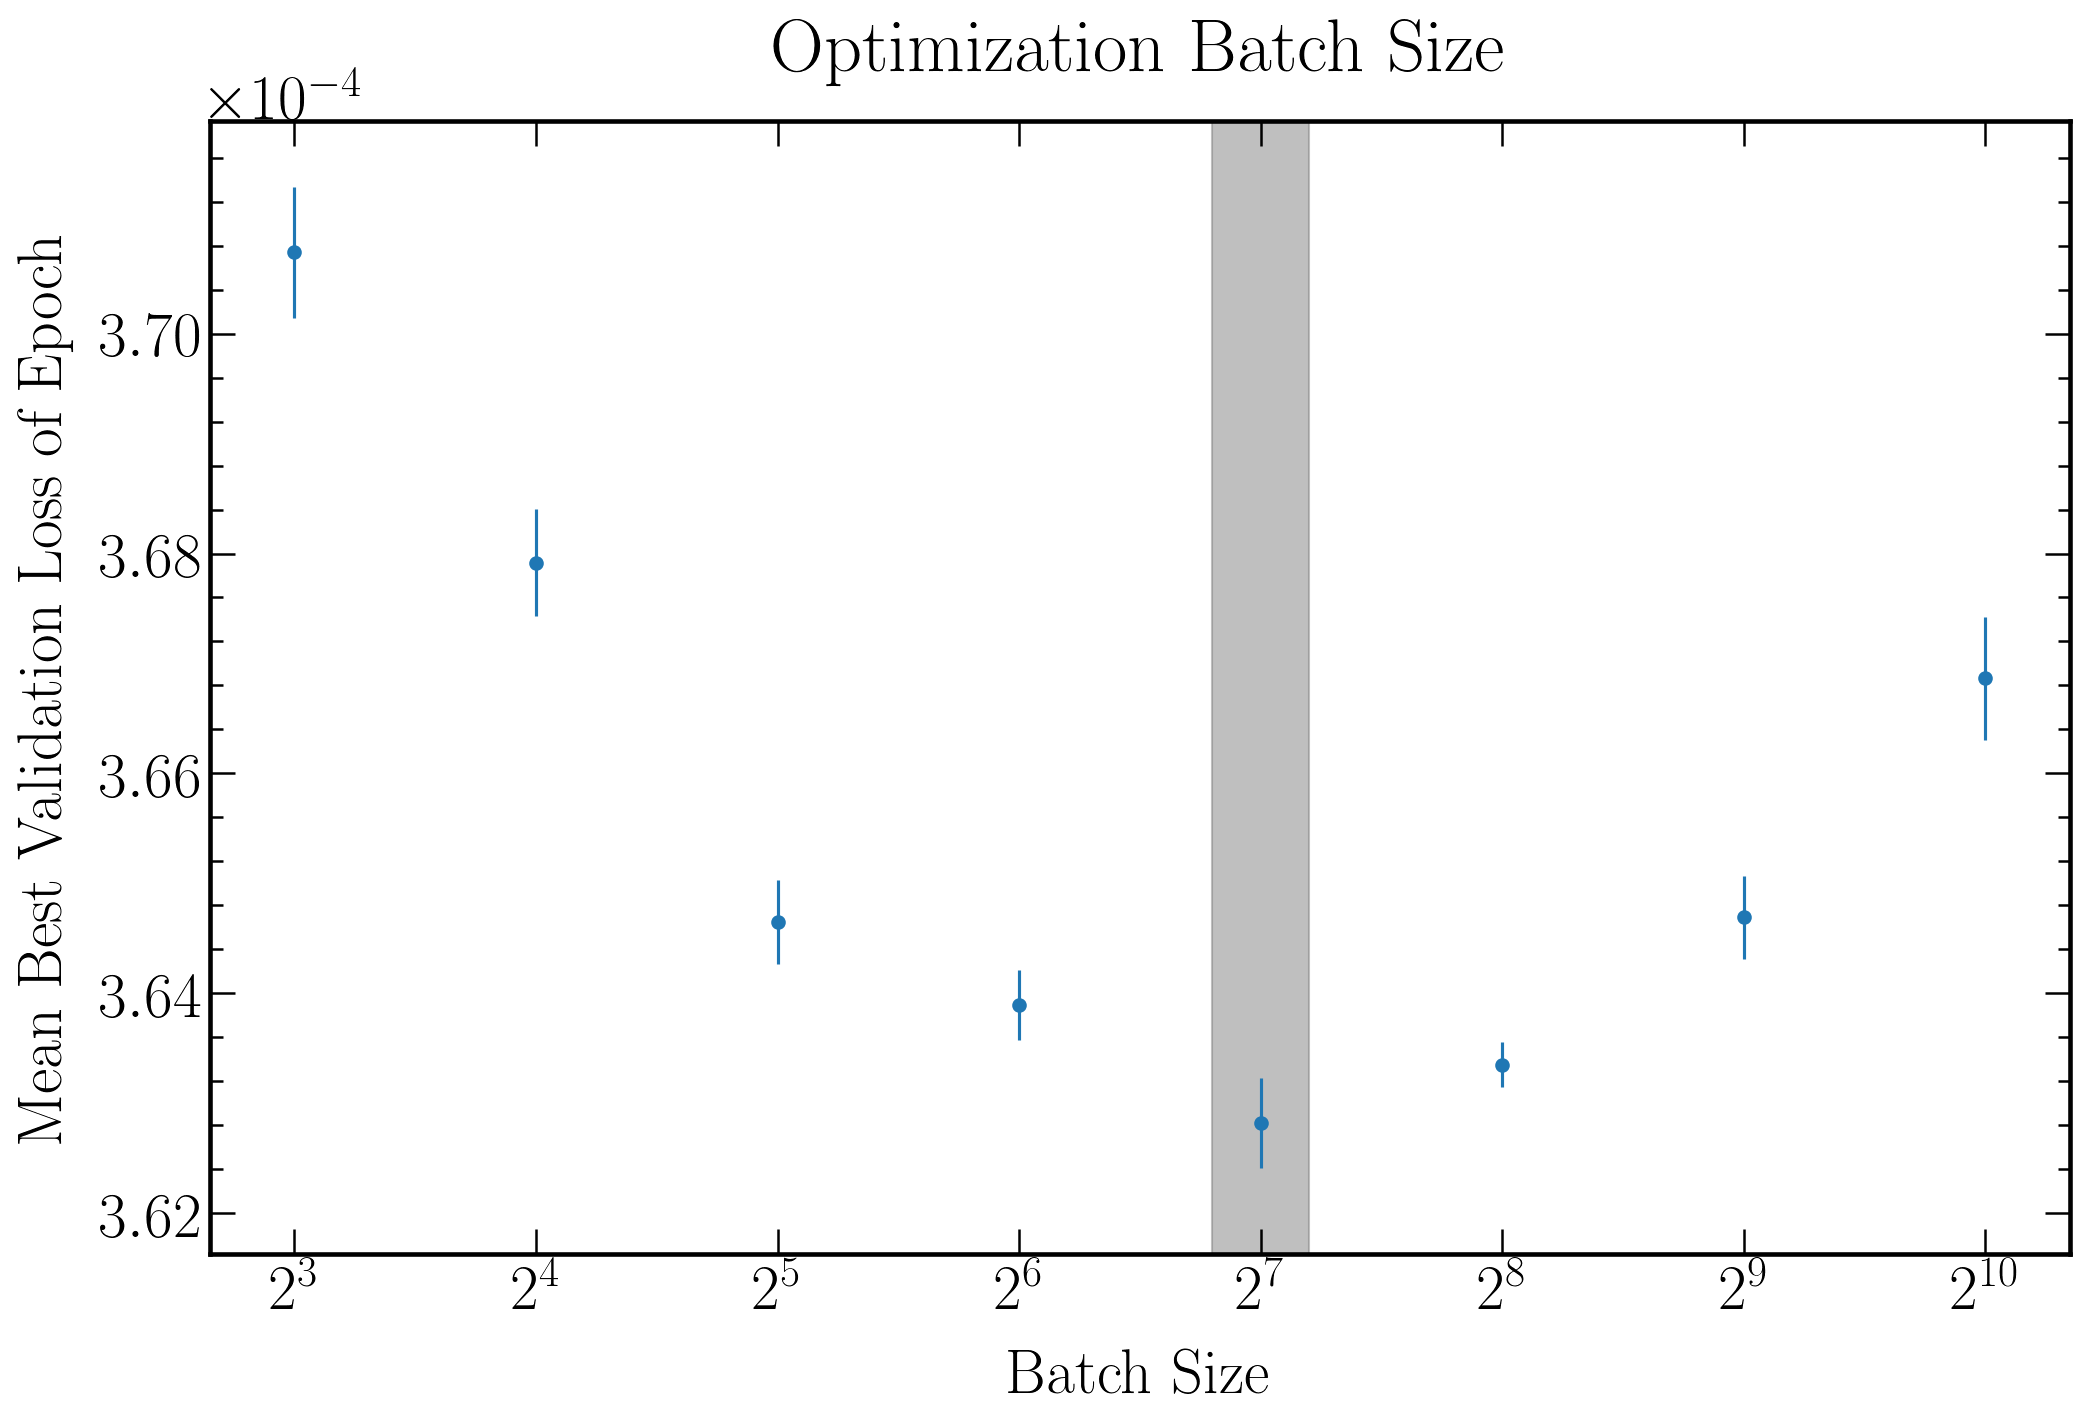

In [60]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

scale_y = 1
matplotlib.rcParams['font.size']=label_size
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.axvspan(2**(6.8), 2**(7.2), alpha=0.5, color='gray')

yerr = (list_par_stds / np.sqrt(list_par_lens))
plt.errorbar(parameters, list_par_means * scale_y, yerr = yerr * scale_y, fmt='o')

plt.xlabel('Batch Size', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Mean Best Validation Loss of Epoch', fontsize = label_size, labelpad = label_pad)
plt.title('Optimization Batch Size', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
plt.ylim((min(list_par_means)-2*max(yerr)) * scale_y, 
         (max(list_par_means)+2*max(yerr)) * scale_y)
#plt.xlim(left=0)
plt.xscale('log', basex=2)

plt.show()

fig.savefig("Optimization_Batch_Size.png")